# Water Management Single Scenario Analysis

This notebook provides a detailed analysis of a single scenario water allocation simulation. The analysis helps understand how different policies affect:
- Actor behavior and cooperation
- Water allocation and usage
- Economic and ecological impacts

## Setup and Configuration

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import src.core as wms
import random
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import seaborn as sns
from types import MethodType

## Policy Definition

Below we define two key policies that regulate water allocation:

1. **Quota Policy**: Determines how much water each actor is allowed to pump
2. **Incentive Policy**: Uses fines and subsidies to influence actor behavior

You can modify these policies to test different regulation strategies.

In [96]:
# Define quota policy - determines how much water each actor is allowed to pump
# This uses the hard_quota policy from the quota_policies module
# In crisis situations, actors with priority below the crisis level get zero quota
import copy


class CrisisLevel:
    NORMAL = -1
    ALERT = 0
    CRISIS = 1
    EXTREME_CRISIS = 2


def fixed_quota(
    self,
    crisis_level: int,
    actors_priority: np.ndarray,
    avg_pump: np.ndarray,
    DOE: float,
    DCR: float,
    ) -> np.ndarray:
    """
    Hard quota policy based on priority and crisis level.
    
    Sets quotas to zero for actors with priority less than the current crisis level.
    
    Args:
        crisis_level: Current water crisis level.
        actors_priority: Priority levels for each actor.
        avg_pump: Average pumping for each actor.
        DOE: Ecological optimal flow threshold.
        DCR: Crisis flow threshold.
        
    Returns:
        Array of water quotas for each actor.
    """

    # This will make higher priority actors having bigger quotas
    # proportional_priority_factor = 1 + ((actors_priority + 1)**1.8 / 10)
    proportional_priority_factor = copy.copy(actors_priority)
    proportional_priority_factor[proportional_priority_factor == 0] = 0.8
    proportional_priority_factor[proportional_priority_factor == 1] = 0.4
    proportional_priority_factor[proportional_priority_factor == 2] = 0.94

    # print("proportional_priority_factor", proportional_priority_factor)
    # print("avg_pump", avg_pump)
    # print("quotas", (avg_pump * proportional_priority_factor))

    if crisis_level == CrisisLevel.NORMAL:
        # Actors will be assigned bigger quotas to avoid them getting penalties and so pumping more
        return (avg_pump * proportional_priority_factor)
    
    else:
        # Crisis times we estimate the available water and we distribute it according to the priority of the actors 
        # Until it reach the ecological acceptable flow
        maximum_amount = 0.0

        match crisis_level:
            case CrisisLevel.ALERT:
                maximum_amount = DOE 
            case CrisisLevel.CRISIS:
                maximum_amount = (DOE + DCR) / 2 
            case CrisisLevel.EXTREME_CRISIS:
                # When already bellow the ecological flow, we don't want anyone to pump
                return np.zeros_like(avg_pump)

        estimated_flow =  maximum_amount * 0.75

        # Repartition by actor priority
        # Sort actors by priority, get indices
        sorted_indices = np.argsort(-actors_priority)
        quotas = np.zeros_like(avg_pump)

        for idx in sorted_indices:
            if estimated_flow <= DCR:
                # If the remaining water is less than DCR, stop allocating, default value already 0
                break
            pump = (avg_pump[idx] * 
                    proportional_priority_factor[idx])
            if estimated_flow - pump >= DCR:
                quotas[idx] = pump
                estimated_flow -= pump
            else:
                # If the remaining water is less than DCR the actor can't pump
                quotas[idx] = 0

        return quotas

def fixed_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:
    """
    Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
    
    Returns an array of incentives (positive values = fines, negative values = subsidies)
    """
    fine = np.zeros(self.nb_actors)
    crisis_level = is_crisis[-1]  # Current crisis level
    
    # If average income is negative, replace it with 0
    avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)
    critical_overall_demand_treshold = np.sum(avg_pump) + DCR
    # Adjusting so the priority value is [0,1] range
    actor_priority = (actors_priority - 0) / (2 - 0)
    # Epsilon [0,0.5] param will help to select the right proportion of policy increase in [0,1] range so the inverse function will be stricly positive          
    # Higher the priority is, lower the factor will be, but factor will still be > 1
    
    # adjusted_priority = actor_priority + 0.1

    adjusted_priority = copy.copy(actor_priority) 

    adjusted_priority[adjusted_priority == 0] = 0.5
    adjusted_priority[adjusted_priority == 1] = 1.6
    adjusted_priority[adjusted_priority == 2] = 1.2
    # print("adjusted_priority", adjusted_priority)

    adjusted_priority_factor = ((1 / adjusted_priority))
    # print("adjusted_priority_factor", adjusted_priority_factor)
    # print(adjusted_priority_factor)
    # As the simulation penalizes less subsidies we push more on it than fines
    # SUBSIDY = -(
    #     # We make 8 times bigger subsidy as the simulation penalize 10 times less
    #     # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines 
    #     (avg_incomes * (0.2 * 2)) * 
    #     adjusted_priority_factor
    # )

    SUBSIDY = -(
        DCR * 20 * adjusted_priority_factor
        )
    # print("DOE",DOE)
    # print("DCR",DCR)
    FINE = (
        (DCR * 5) * 
        adjusted_priority_factor**2
    )

    # print("------------------")
    # print("actors prio:", actors_priority)
    # print("adjusted_priority_factor:", adjusted_priority_factor)
    # print("avg_incomes:", avg_incomes)
    # print("params[FINE_INCOME_BASE_CALCULATION]:", params["FINE_INCOME_BASE_CALCULATION"])
    # print("FINE", FINE)
    # print("SUBSIDY", SUBSIDY)
    # print("------------------")

    exceding_quota_idx = water_pump > quota
    respecting_quota_idx = water_pump <= quota
    
    exceding_avg_pump_idx = avg_pump  < water_pump
    respecting_avg_pump_idx = avg_pump >= water_pump

    excess_pump_factor = (water_pump - (avg_pump * .8))
    # print("excess_pump_factor : ",excess_pump_factor)
    if water_flows[-1] < critical_overall_demand_treshold and crisis_level == CrisisLevel.NORMAL:
        # We anticipate a near crisis situation so we start applying fines
        # But it won't be as strong as in a real crisis

        fine[exceding_quota_idx] = FINE[exceding_quota_idx] * 0.75
        fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * 0.75
        # print("excess_pump_factor", excess_pump_factor)
        
        # fine[excess_pump_factor < 0] = FINE[excess_pump_factor < 0] * (excess_pump_factor[excess_pump_factor < 0] * 10)
        # print("fine :",fine)
        
        return fine
    
    if water_flows[-1] >= critical_overall_demand_treshold:
    #     # In normal times we try to push cooperation slightly but not too much so econ impect is kept high
        fine[exceding_quota_idx] = FINE[exceding_quota_idx] * 0.2
        fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * 0.2

    #     # fine[excess_pump_factor < 0] = FINE[excess_pump_factor < 0] * (excess_pump_factor[excess_pump_factor < 0] * 10)
    #     # print("fine :",fine)

        return fine
    
    if crisis_level != CrisisLevel.NORMAL:
        # The more the crisis is critical, the more the fine/subsidies will be
        # [1.2, 1.3, 1.4]
        crisis_factor = 1 + ((crisis_level + 2) / 10)
        
        actors_priority_below_crisis = actors_priority < crisis_level
        actors_priority_above_crisis = actors_priority >= crisis_level

        # Defectors
        # Below priority and exceeding
        actors_exceding_and_below_priority_idx = actors_priority_below_crisis == exceding_quota_idx
        fine[actors_exceding_and_below_priority_idx] = (
                FINE[actors_exceding_and_below_priority_idx] * 
                1.3 *
                crisis_factor
            )
        # Above priority and exceeding
        actors_exceding_and_above_priority_idx = actors_priority_above_crisis == exceding_quota_idx
        fine[actors_exceding_and_above_priority_idx] = FINE[actors_exceding_and_above_priority_idx]

        # Cooperators
        # Below priority and respecting
        actors_respecting_and_below_priority_idx = actors_priority_below_crisis == respecting_quota_idx
        fine[actors_respecting_and_below_priority_idx] =(
                SUBSIDY[actors_respecting_and_below_priority_idx] * 
                1.3 * 
                crisis_factor
            )
        # Above priority and respecting
        actors_respecting_and_above_priority_idx = actors_priority_above_crisis == respecting_quota_idx
        fine[actors_respecting_and_above_priority_idx] = SUBSIDY[actors_respecting_and_above_priority_idx]
        return fine
    
    return fine

## Simulation Configuration and Execution

Now we'll configure and run the simulation with our defined policies:

In [97]:
# Configure simulation parameters
yaml_path = 'parameters/scenarios/0.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 700        # Number of weeks to simulate
params["nb_iterations"] = 20       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  

# Initialize and run simulation
simulation = wms.WaterManagementSimulation(**params)

# Apply our custom policies
simulation.incentive_policy = MethodType(fixed_incentive_policy, simulation)
simulation.compute_actor_quota = MethodType(fixed_quota, simulation)

# Run the simulation
simulation.run_simulation()

# Get final performance scores
ecological_impact, economic_impact, ok_satisfaction = simulation.get_final_scores_scaled()

print(f"Simulation complete. Final scores:")
print(f"Ecological Impact: {ecological_impact:.4f} (lower is better)")
print(f"Economic Impact: {economic_impact:.4f} (higher is better)")

# Prepare for visualization
sns.set(style='whitegrid')
cmap = plt.get_cmap('Dark2')
actors_colors = [cmap(i) for i in range(simulation.nb_actors)]
x_values = range(params["total_turns"])

Violation: medium-priority actors must outperform low-priority actors by factor 1.0004135714285713
High satisfaction: 0.867058268826574 Medium satisfaction: 0.7468426579857271 Low satisfaction: 0.8447390228158796
Penalty applied for medium-priority actors not outperforming low-priority actors.
Simulation complete. Final scores:
Ecological Impact: 0.7657 (lower is better)
Economic Impact: -0.7374 (higher is better)


## 1. Water Resource Analysis

First, let's examine the water resource availability throughout the simulation period and how it relates to actor demands.

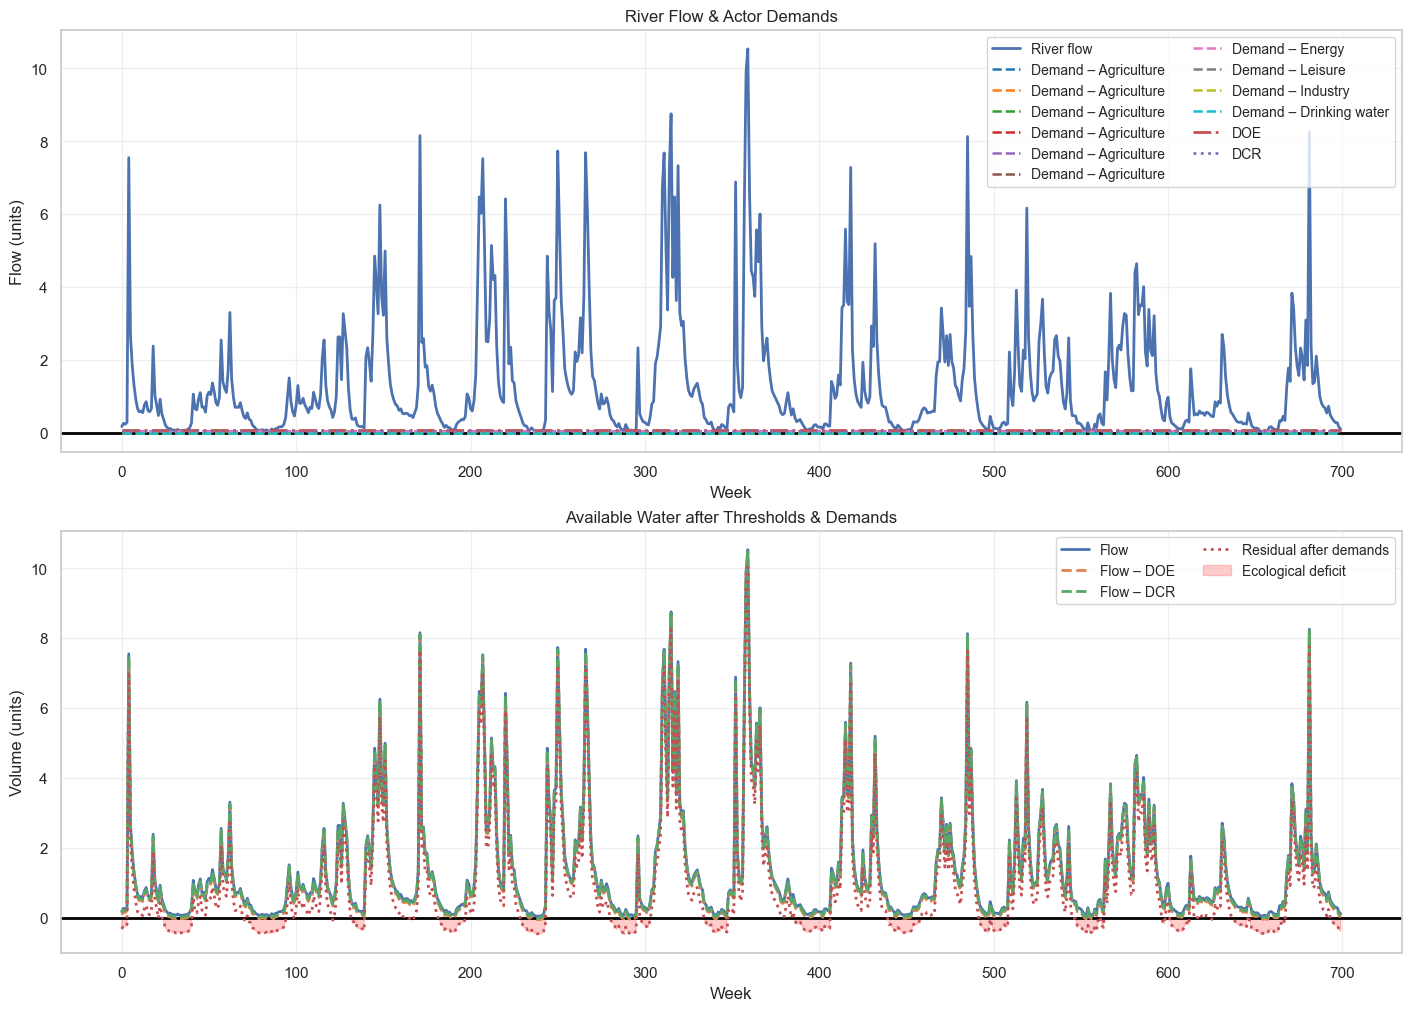

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot river flow
gtp.plot_river_flow(axes[0], x_values, simulation)

# Plot remaining water after ecological threshold
gtp.plot_remaining_water(axes[1], x_values, simulation)

plt.show()

### Analysis of Water Resources

The top graph shows the raw river flow over time, along with each actor's water demand and the ecological threshold (DCR). The total demand line shows the sum of all actor demands.

The bottom graph shows the remaining water available for allocation after respecting the ecological threshold. When this line drops below zero (red shaded areas), it indicates periods where fulfilling all demands would breach the minimum environmental flow requirements.

## 2. Actor Behavior and Crisis Response

Now, let's analyze how actors behave in response to changing water availability and crisis levels.

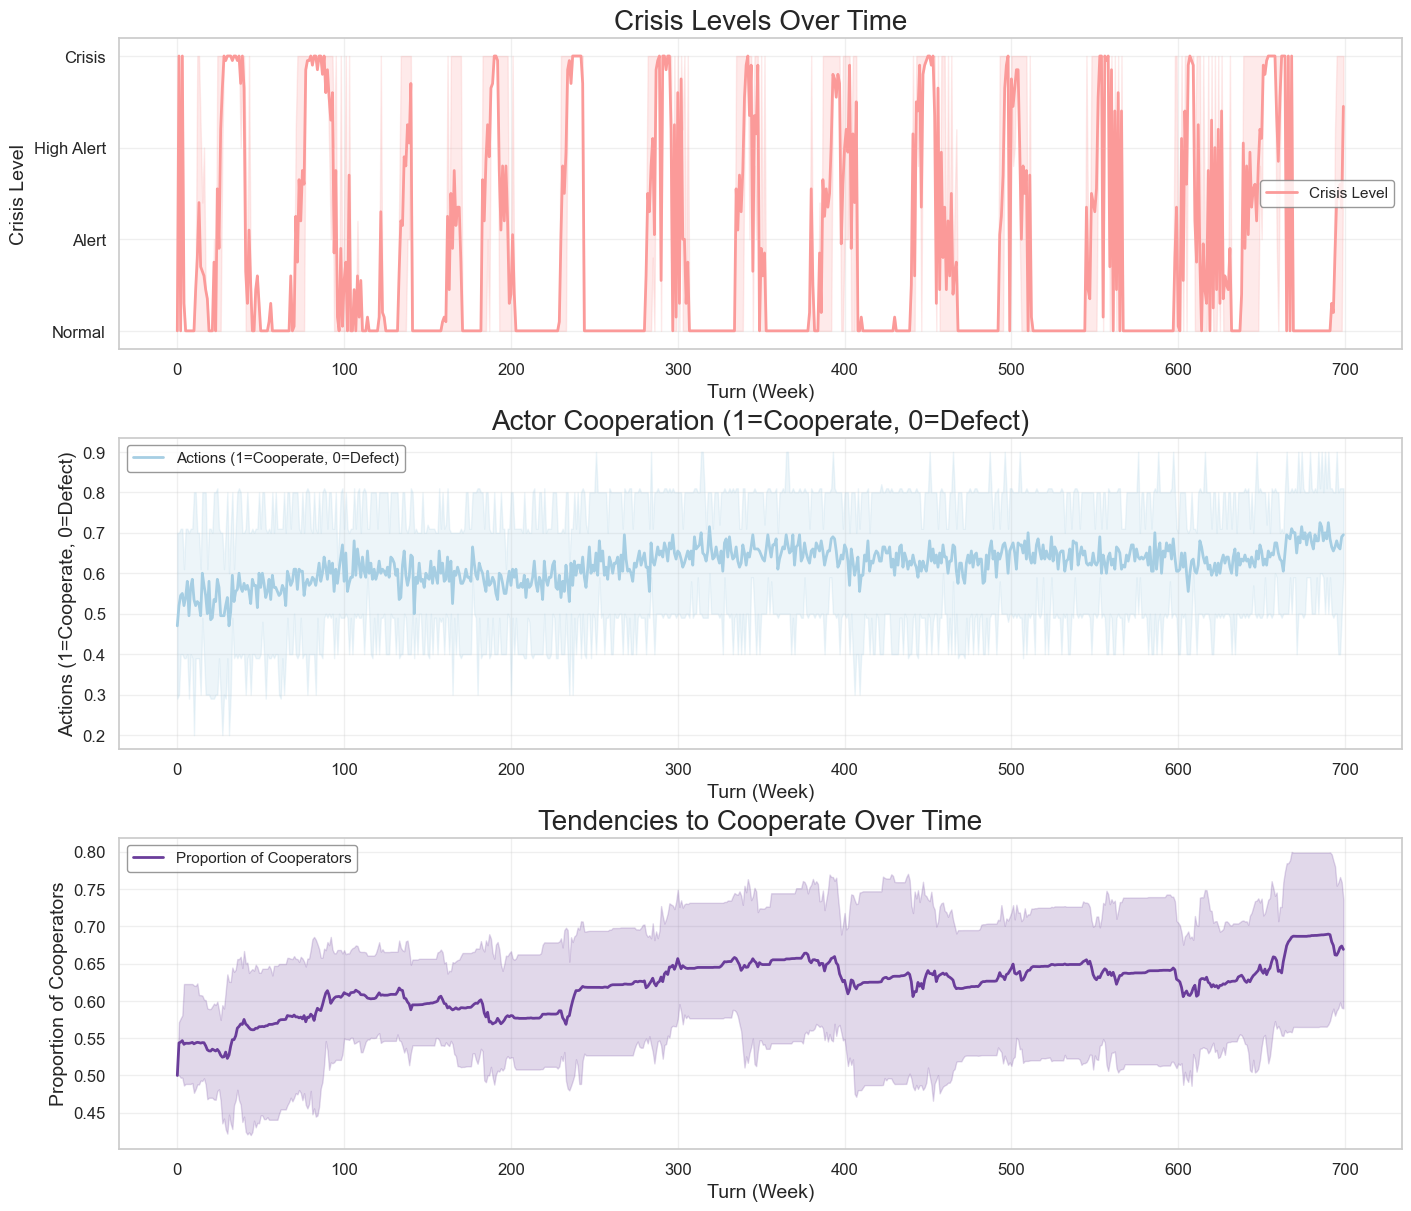

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot crisis levels
gtp.plot_data(axes[0], x_values, simulation, "w_crisis", mode="mean")
axes[0].set_title('Crisis Levels Over Time', fontsize=20)
axes[0].set_ylim(-1.2, 2.2)
axes[0].set_yticks([-1, 0, 1, 2])
axes[0].set_yticklabels(['Normal', 'Alert', 'High Alert', 'Crisis'])

# Plot actor cooperation actions
gtp.plot_data(axes[1], x_values, simulation, "h_actions", mode="mean")
axes[1].set_title('Actor Cooperation (1=Cooperate, 0=Defect)', fontsize=20)

# Plot tendencies to cooperate
gtp.plot_data(axes[2], x_values, simulation, "h_tendencies", mode="mean")
axes[2].set_title('Tendencies to Cooperate Over Time', fontsize=20)

plt.show()

### Analysis of Actor Behavior

These graphs reveal how actors respond to crisis situations:

- The **Crisis Level** graph shows when the system enters different states of water stress.
- The **Actor Cooperation** graph shows actors' decisions to either cooperate (1) or defect (0).
- The **Tendencies to Cooperate** graph shows the evolving probability of cooperation for each actor.

Notice how cooperation tendencies change in response to crisis events. This reveals how actors learn from experience and adapt their strategies based on outcomes.

## 3. Water Allocation and Economic Outcomes

Next, let's examine how water is allocated among actors and its economic impacts.

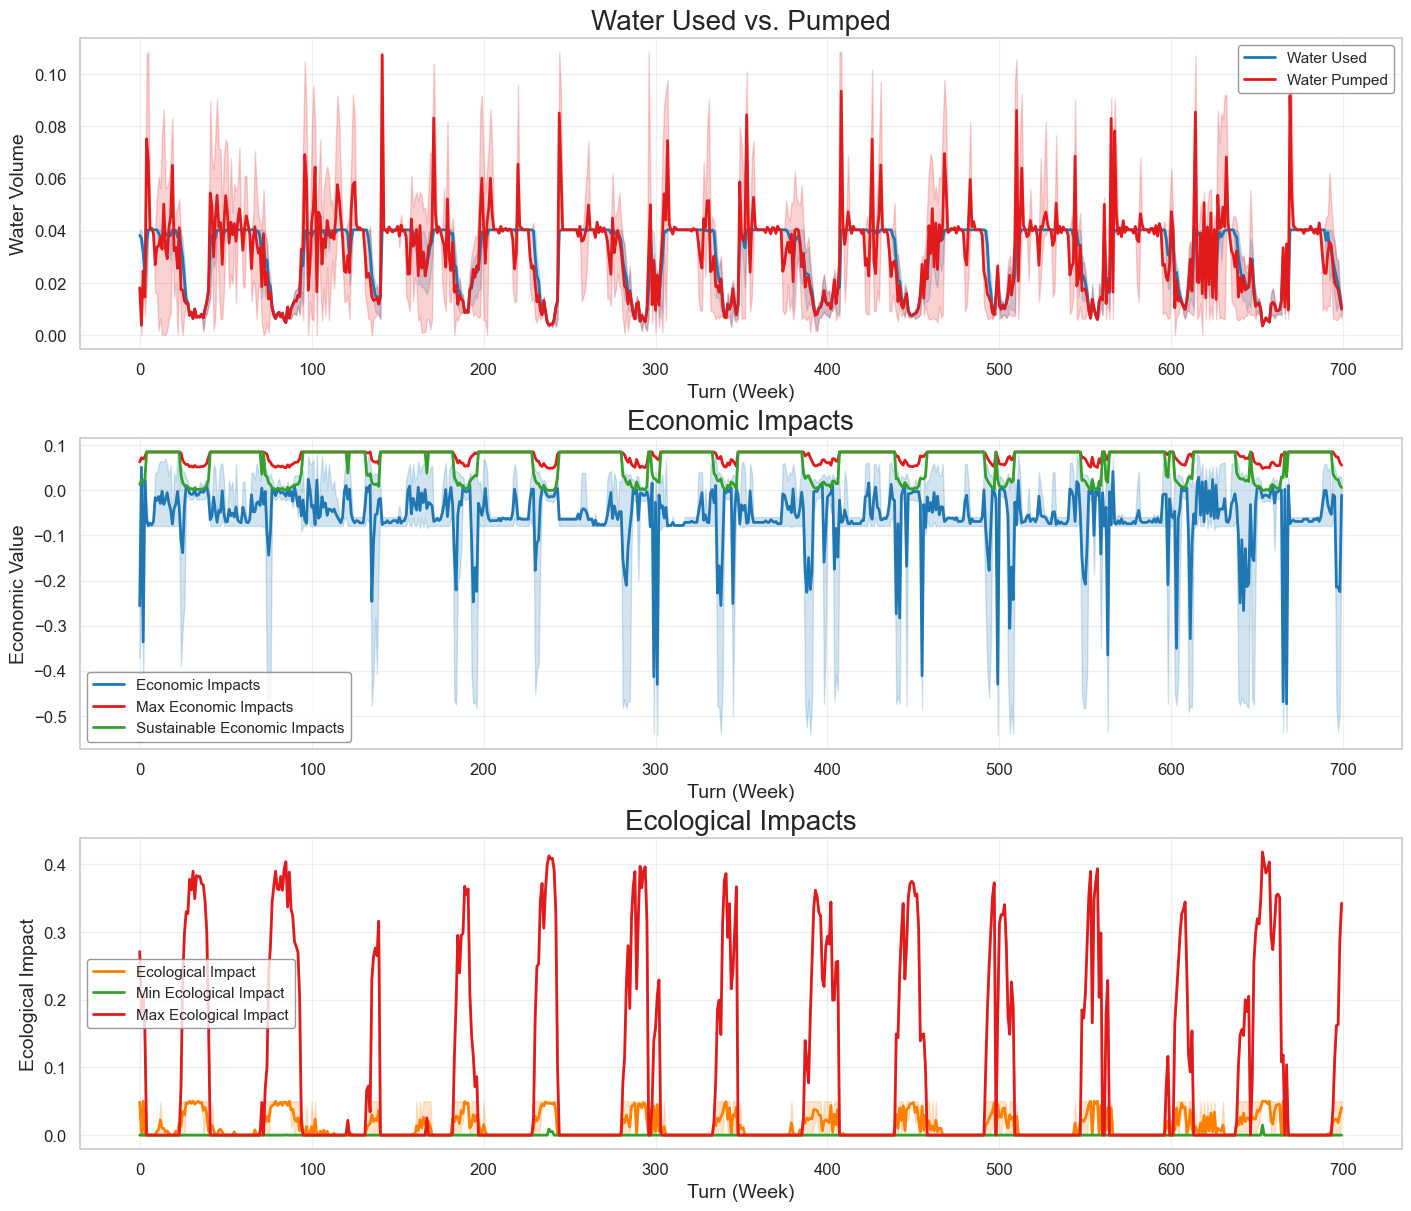

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot water usage
gtp.compare_data(
    axes[0], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Water Volume',
    title='Water Used vs. Pumped'
)

# Plot economic impacts
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Economic Value',
    title='Economic Impacts'
)

# Plot ecological impacts
gtp.compare_data(
    axes[2], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Ecological Impact',
    title='Ecological Impacts'
)

plt.show()

### Analysis of Allocation and Impacts

These graphs show the outcomes of the water allocation process:

- **Water Used vs. Pumped**: Compares water pumped from the river to water actually used. The difference goes into storage.
- **Economic Impacts**: Shows the actual economic value generated compared to theoretical maximum and sustainable minimum values.
- **Ecological Impacts**: Shows the environmental impact of water usage compared to minimum and maximum possible impacts.

These metrics help evaluate how well the policy balances economic benefits against ecological integrity.

## 4. Policy Effectiveness Analysis

Now let's analyze how the incentive policy (fines and subsidies) influenced actor behavior.

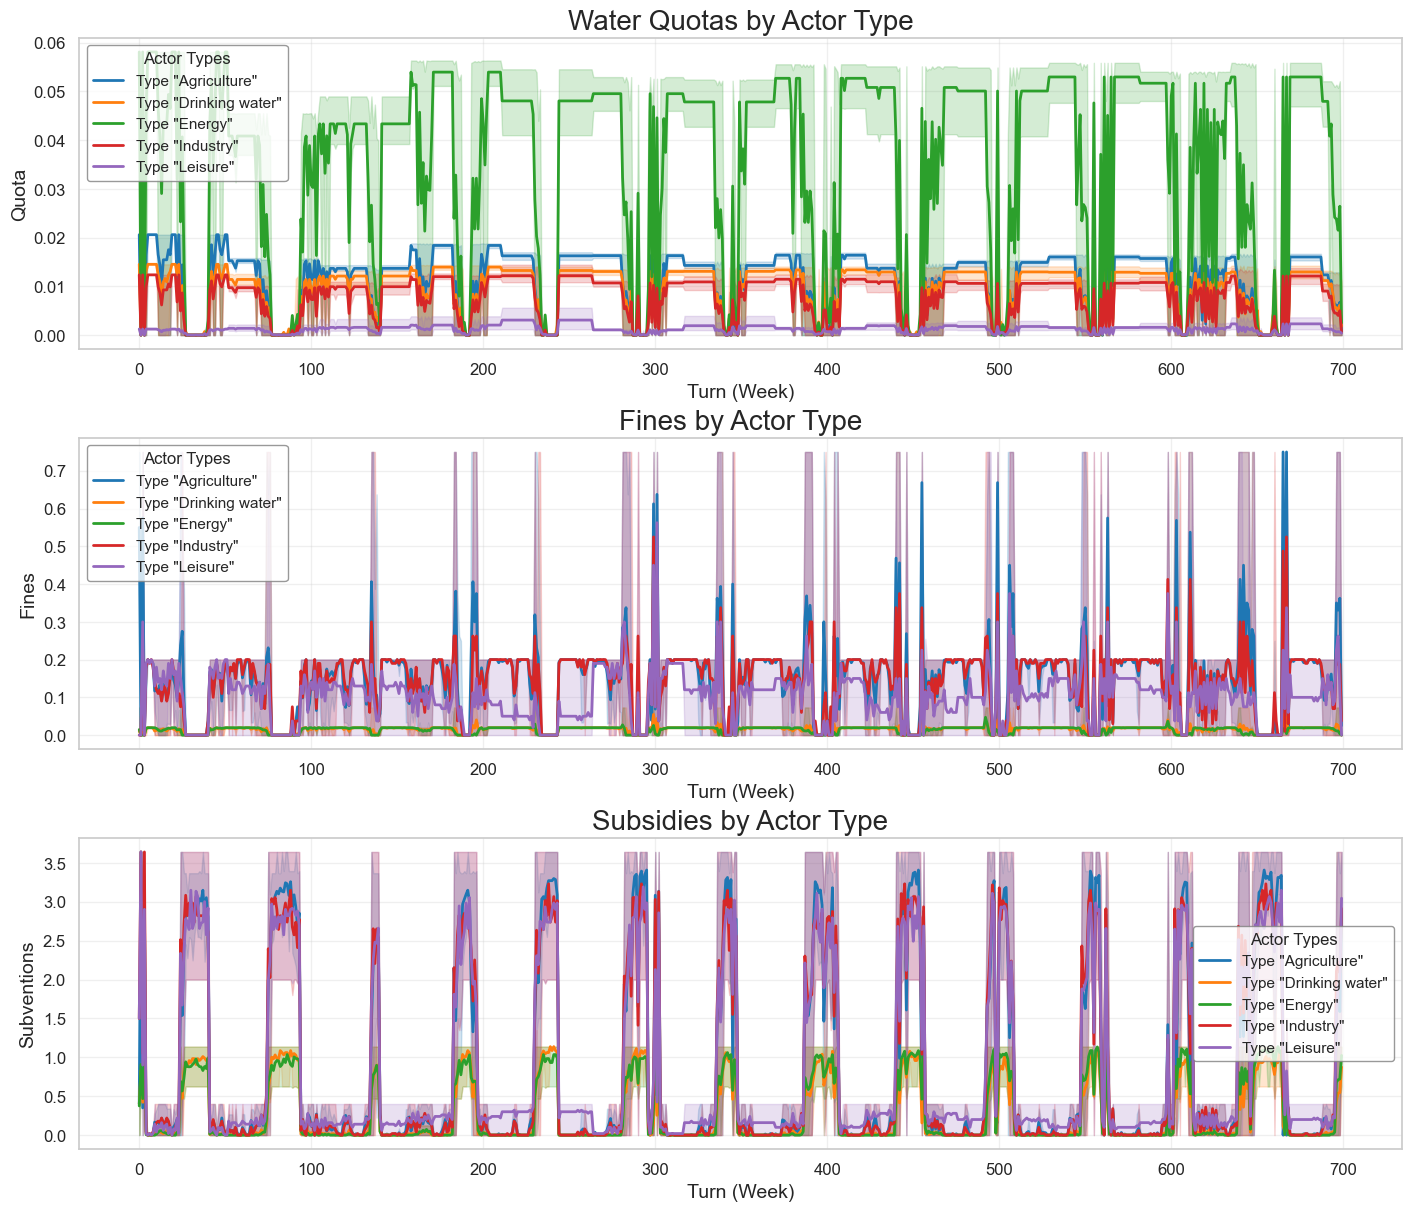

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot quotas by actor type
gtp.plot_actor_data_by_type(axes[0], x_values, simulation, "h_quota", mode="actors_mean")
axes[0].set_title('Water Quotas by Actor Type', fontsize=20)

# Plot fines and subsidies 
gtp.plot_actor_data_by_type(axes[1], x_values, simulation, "h_fines", mode="actors_mean")
axes[1].set_title('Fines by Actor Type', fontsize=20)

gtp.plot_actor_data_by_type(axes[2], x_values, simulation, "h_subventions", mode="actors_mean")
axes[2].set_title('Subsidies by Actor Type', fontsize=20)

plt.show()

### Analysis of Policy Interventions

These graphs reveal how the incentive policy worked:

- **Water Quotas**: Shows the allowed water allocation for each actor type over time.
- **Fines**: Shows penalties applied when actors exceeded their quotas.
- **Subsidies**: Shows incentives given to encourage cooperation.

The effectiveness of these tools can be evaluated by comparing them to the cooperation tendencies seen earlier.

## 5. Cumulative Impact Analysis

Finally, let's examine the cumulative impacts over the entire simulation period.

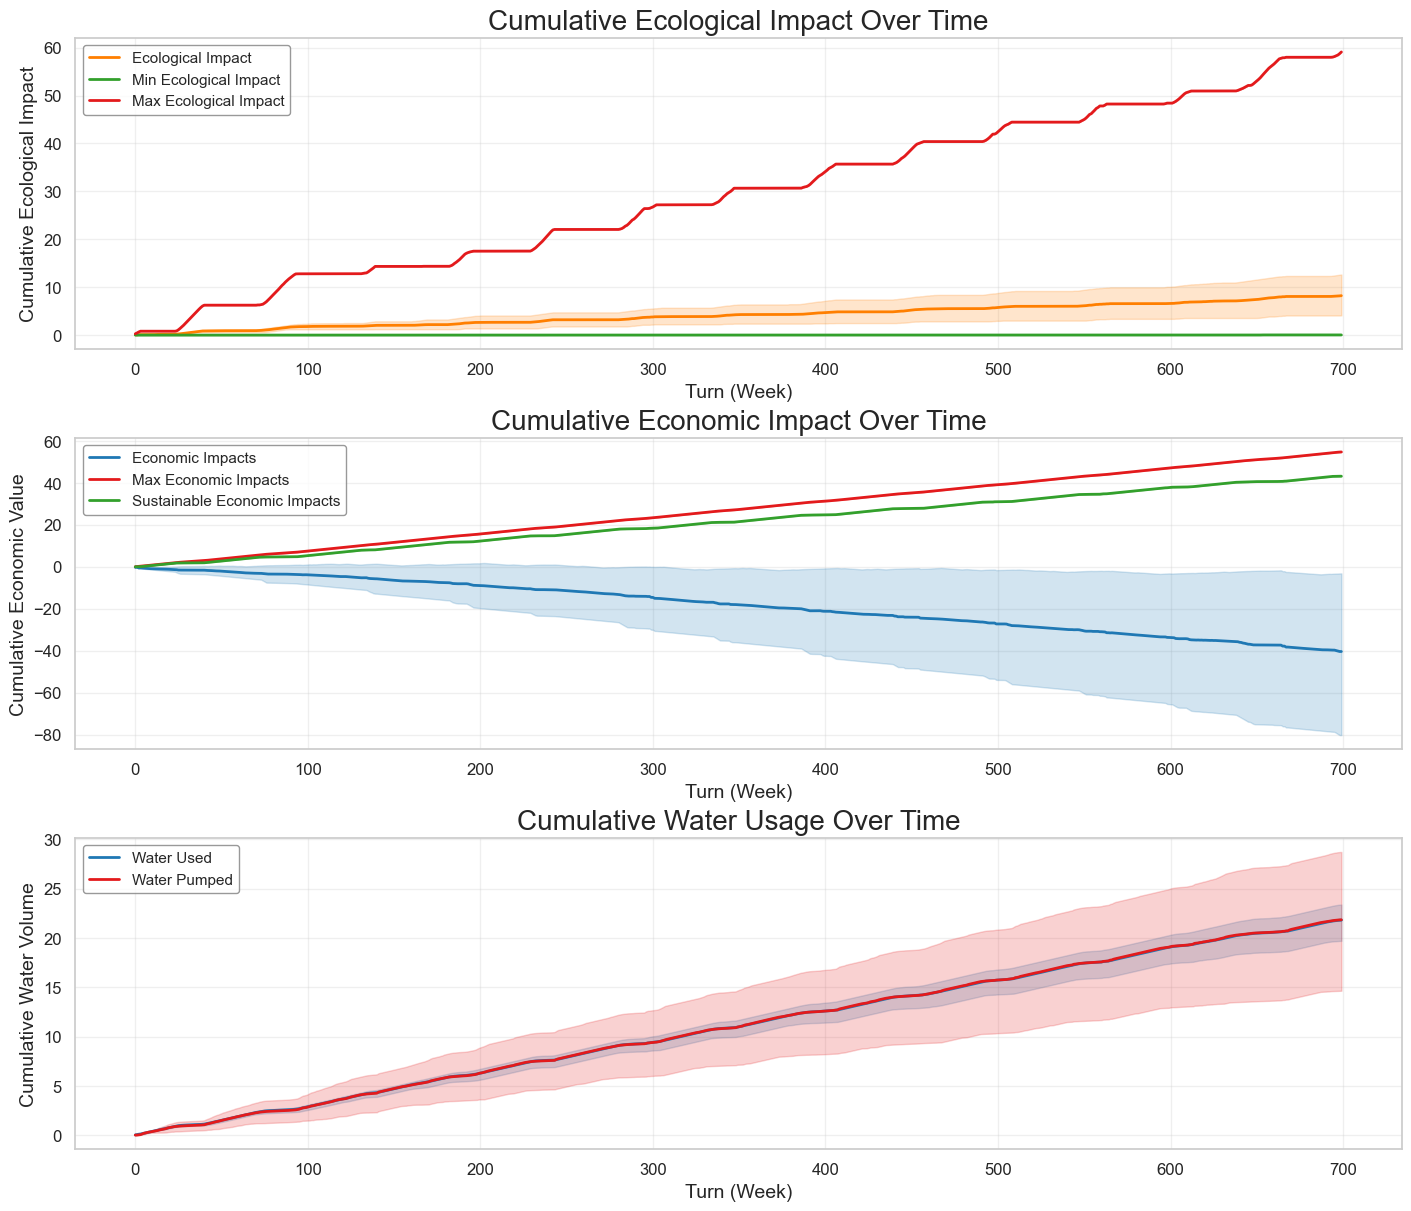

In [102]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Cumulative ecological impact
gtp.compare_data(
    axes[0], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Ecological Impact',
    title='Cumulative Ecological Impact Over Time',
    cumulative=True
)

# Cumulative economic impact
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Economic Value',
    title='Cumulative Economic Impact Over Time',
    cumulative=True
)

# Cumulative water usage
gtp.compare_data(
    axes[2], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Water Volume',
    title='Cumulative Water Usage Over Time',
    cumulative=True
)

plt.show()

### Analysis of Cumulative Impacts

These graphs show the long-term, cumulative outcomes of the policy:

- **Cumulative Ecological Impact**: Shows the total environmental impact over time.
- **Cumulative Economic Impact**: Shows the total economic value generated over time.
- **Cumulative Water Usage**: Shows the total water pumped and used over time.

These cumulative metrics are useful for evaluating the overall performance of the policy across the entire simulation period.

## 6. Actor-Specific Analysis

For a deeper understanding, let's examine how individual actors behaved.

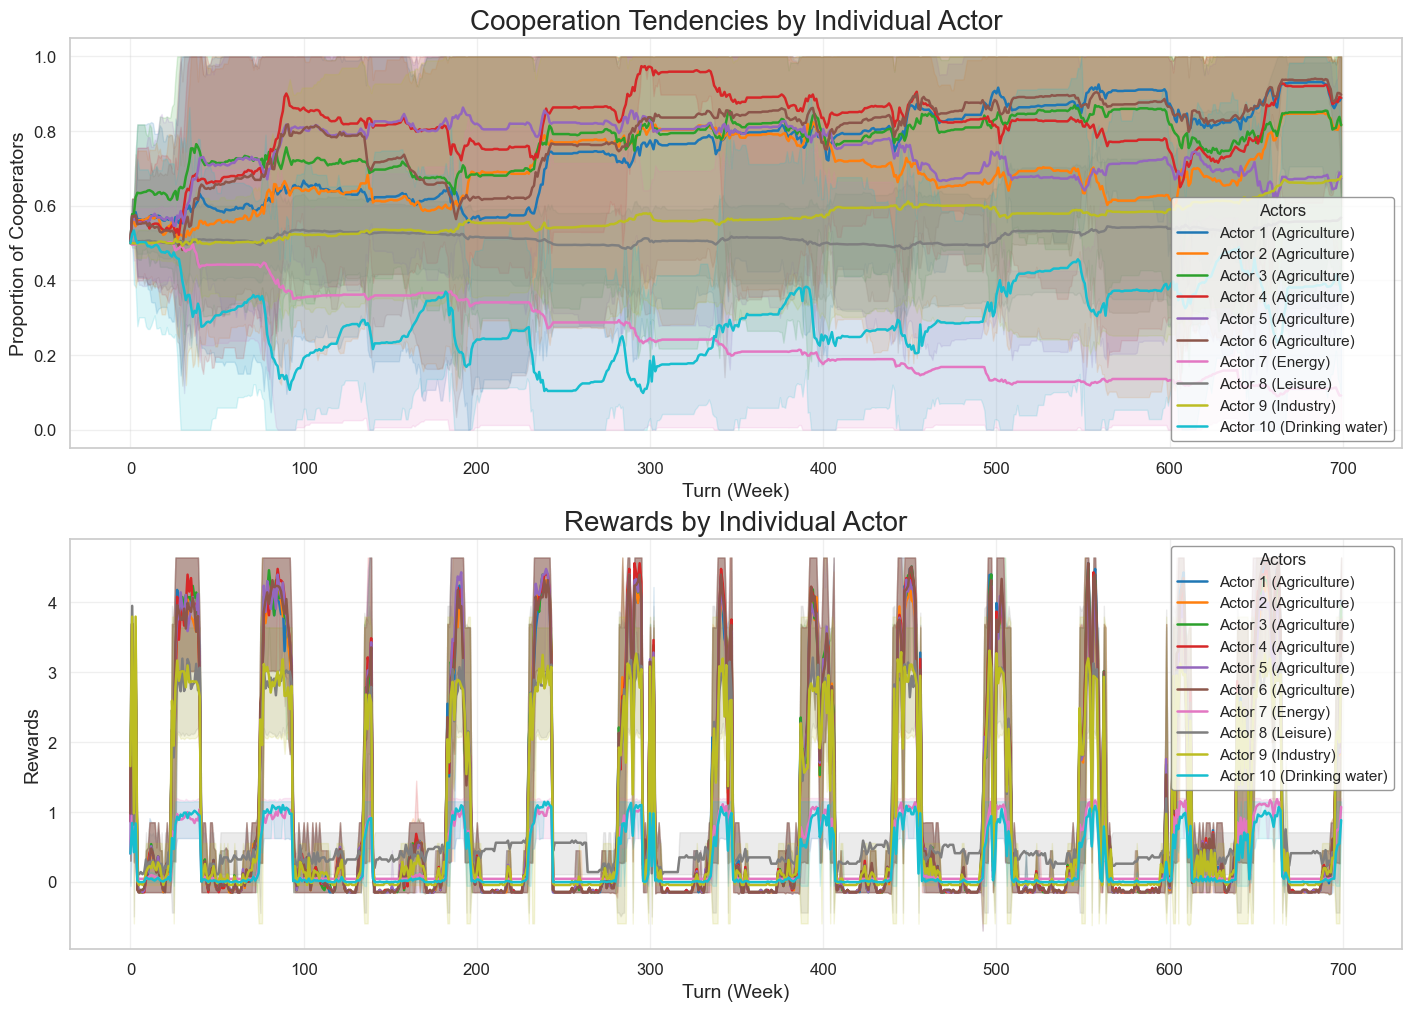

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot cooperation tendencies for individual actors
gtp.plot_actor_data(axes[0], x_values, simulation, "h_tendencies")
axes[0].set_title('Cooperation Tendencies by Individual Actor', fontsize=20)

# Plot rewards for individual actors
gtp.plot_actor_data(axes[1], x_values, simulation, "h_rewards")
axes[1].set_title('Rewards by Individual Actor', fontsize=20)

plt.show()

### Analysis of Individual Actor Behavior

These graphs provide actor-specific insights:

- **Cooperation Tendencies**: Shows how each individual actor's tendency to cooperate evolved over time.
- **Rewards**: Shows the economic rewards received by each actor.

Notice how different actors may have different strategies based on their priority, demand, and other characteristics.

## Conclusion

This analysis demonstrates how water allocation policies can influence actor behavior and overall system outcomes. The key insights are:

1. Water scarcity triggers crisis situations that require cooperation to manage effectively
2. Actors adapt their behavior based on incentives and outcomes
3. Policies must balance economic benefits against ecological integrity
4. Different actor types respond differently to incentives based on their priorities and needs

By testing different policy settings in this simulation, you can develop more effective water management strategies that promote cooperation while maintaining environmental flows.

## Next Steps

To further improve the policy, consider:

1. Adjusting quota calculations based on precise water availability
2. Fine-tuning incentive levels to better influence cooperation
3. Testing different policy combinations under various scarcity scenarios
4. Adding additional mechanisms like water trading or resource pooling